**Titulo:** Exercício 7 - Deteção de anomalias em séries temporais <br>
**Autor:** Juan Sebastián Beleño Díaz <br>
**Data:** 21 de Novembro de 2016 <br>

## Introdução
Neste trabalho vai ser apresentado um algoritmo de deteção de anomalias em séries temporais baseado em média e desvio padrão. Além disso, vou apresentar um algoritmo para selecionar o tamanho dos trechos nas séries temporais.

## Dados
Os arquivos usados neste trabalho são séries temporais com diferentes anomalias: [série temporal 1](http://www.ic.unicamp.br/~wainer/cursos/2s2016/ml/serie1.csv), [série temporal 2](http://www.ic.unicamp.br/~wainer/cursos/2s2016/ml/serie2.csv), [série temporal 3](http://www.ic.unicamp.br/~wainer/cursos/2s2016/ml/serie3.csv), [série temporal 4](http://www.ic.unicamp.br/~wainer/cursos/2s2016/ml/serie4.csv). Finalmente, o algoritmo apresentado tem que ser implementado na deteção de anomalias na [série temporal 5](http://www.ic.unicamp.br/~wainer/cursos/2s2016/ml/serie5.csv). Todos os arquivos tem duas colunas, uma com o *timestamp* e a outra com o *value*. No entanto, este trabalho vai usar o índice invés do *timestamp*.

## Preparação dos dados
Antes de começar trablahar com os dados é preciso incluir as dependecias do projeto:


In [1]:
%matplotlib inline

# Loading the libraries
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

Existem muitas maneiras de abrir os arquivos e obter os dados, mas neste caso foi usado pandas para obter os dataframes diretamente desde a URL.

In [2]:
url_serie_1 = 'http://www.ic.unicamp.br/~wainer/cursos/2s2016/ml/serie1.csv'
url_serie_2 = 'http://www.ic.unicamp.br/~wainer/cursos/2s2016/ml/serie2.csv'
url_serie_3 = 'http://www.ic.unicamp.br/~wainer/cursos/2s2016/ml/serie3.csv'
url_serie_4 = 'http://www.ic.unicamp.br/~wainer/cursos/2s2016/ml/serie4.csv'
url_serie_5 = 'http://www.ic.unicamp.br/~wainer/cursos/2s2016/ml/serie5.csv'

df_serie_1 = pd.read_csv(url_serie_1, header= 0)
df_serie_2 = pd.read_csv(url_serie_2, header= 0)
df_serie_3 = pd.read_csv(url_serie_3, header= 0)
df_serie_4 = pd.read_csv(url_serie_4, header= 0)
df_serie_5 = pd.read_csv(url_serie_5, header= 0)

# Selecting the time series without timestamp
ts1 = np.ravel(df_serie_1['value'])
ts2 = np.ravel(df_serie_2['value'])
ts3 = np.ravel(df_serie_3['value'])
ts4 = np.ravel(df_serie_4['value'])
ts5 = np.ravel(df_serie_5['value'])

## Vetor descritor
Neste trabalho vou usar um descritor composto de um vetor de [média, desvio padrão] para o trecho da série temporal. Cada trecho tem uma superposição de (N - 1) pontos em trechos vizinhos, em que N é o tamanho do trecho.

In [3]:
# Creates the descriptor (mean, standard deviation)
# ts: a vector of Time Series
# N: the length of the subsequence considered
def get_descriptor(ts, N):
    
    mean = []
    std = []
    M = len(ts)
    
    for i in range(0, M - N + 1 ):
        mean.append(np.mean(ts[i:i + N]))
        std.append(np.std(ts[i:i + N]))        
        
    return[mean, std]

## Algoritmo de deteção de anomalias
O algoritmo apresentado neste trabalho para a deteção de anomalias basea-se no suposto de uma distribuição normal em cada trecho da série temporal. Portanto, um trecho **A** é similar a outro trecho **B** se a média do trecho **B** está no intervalo da média do trecho **A** mais ou menos o desvio padrão de **A**. O algoritmo utiliza um vetor para contar o número de trechos similares a cada trecho. O valor mínimo do vetor é uma anomalia porque tem menos similaridade com outro trechos.

In [4]:
# Matches each descriptor against others to find similarities based on
# pertecentage, i.e. for each descriptor we assume that there is a similarity 
# if the mean and stardard deviation does not change more than a percentage
# compared with other descriptor. Finally, we count the number of similar 
# descriptors and those with less similarities are anomalies
def match_descriptors(mean, std, p_limit = 2):
    
    K = len(mean)
    match_vector = []
    
    for i in range(0, K):
        counter = 0
        for j in range(0, K):
            p_mean = 0
            p_std = 0
            
            # I'm assming a gaussian distribution here
            # p_limit = 2 => 95% of confidence
            if(mean[j] <= (mean[i] + std[i] * p_limit) and mean[j] >= (mean[i] - std[i] * p_limit)):
                counter = counter + 1
            
                
        match_vector.append(counter)
    
    return match_vector

## Algoritmo de cálculo do tamanho dos trechos
O algoritmo apresentado nesta seção faz dois vetores diferentes, um para medir o número de pontos consecutivos que tem valor acima da média da série temporal e o outro para medir o número de pontos consecutivos que tem valor abaixo da média da série temporal. O máximo valor dos trecho dos dois vetores é calculado e o tamanho do trecho pode ser o máximo do vetor de valores acima da média ou a diferença entre o valor máximo do vetor de valores abaixo da média e o máximo do vetor de valores acima da média.

In [5]:
# This function finds the size of the subsequence in the time series,
# counting the number of points in sequence above the mean, and also counting
# the number of points in sequence below the mean. We calculate the max 
# sequence for points above and below the mean and based on that we 
# choose the max sequence above or the substraction between max sequence
# below and max sequence above.
def find_N(ts):
    
    mean = np.mean(ts)
    subseq_up_arr = []
    subseq_down_arr = []
    subseq_up_length = 0
    subseq_down_length = 0

    for value in ts:
        if value > mean:
            subseq_up_length = subseq_up_length + 1
            if subseq_down_length > 0:
                subseq_down_arr.append(subseq_down_length)
                subseq_down_length = 0
        else:
            subseq_down_length = subseq_down_length + 1
            if subseq_up_length > 0:
                subseq_up_arr.append(subseq_up_length)
                subseq_up_length = 0
    
    subseq_up_max = np.amax(subseq_up_arr)
    subseq_down_max = np.amax(subseq_down_arr)
    subseq_relationship = subseq_down_max / subseq_up_max
    wavelength = 0
    
    if(subseq_relationship > 3  and subseq_relationship < 5):
        wavelength = subseq_down_max - subseq_up_max
    else:
        wavelength = subseq_up_max
        
    
    return wavelength

## Validando o algoritmo
Primeiro é feito um algoritmo para diminuir o conjunto de linhas de código para gerar as imagens e os resultados da validação.

In [6]:
# Takes the time serie and find a wavelength to execute an anomaly detection
# Finally, it plots the time serie and the anomaly
def show_anomaly(ts):
    
    ts_length = len(ts)
    wavelength = math.floor(find_N(ts))

    descriptor = get_descriptor(ts, wavelength)
    mean = descriptor[0]
    std = descriptor[1]

    match_descriptor = match_descriptors(mean, std)
    anomaly_index = np.argmin(match_descriptor)
    
    # This is hacky just to make visible the anomaly in the pĺot
    # because in some case the anomaly size is so little it can't be
    # plotted
    if(wavelength < 10):
        wavelength = 10
    
    fig_width = 16
    fig_height = 8
    fig_dpi = 100
    plt.figure(figsize=(fig_width, fig_height), dpi=fig_dpi)
    
    plt.plot(range(0,ts_length), ts, '#ff5722', 
             range(anomaly_index,(anomaly_index + wavelength)),
             ts[range(anomaly_index,(anomaly_index + wavelength))],
             '#009688')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

Finalmente, o algoritmo é validado usando todas as séries temporais e plotando os resultados.

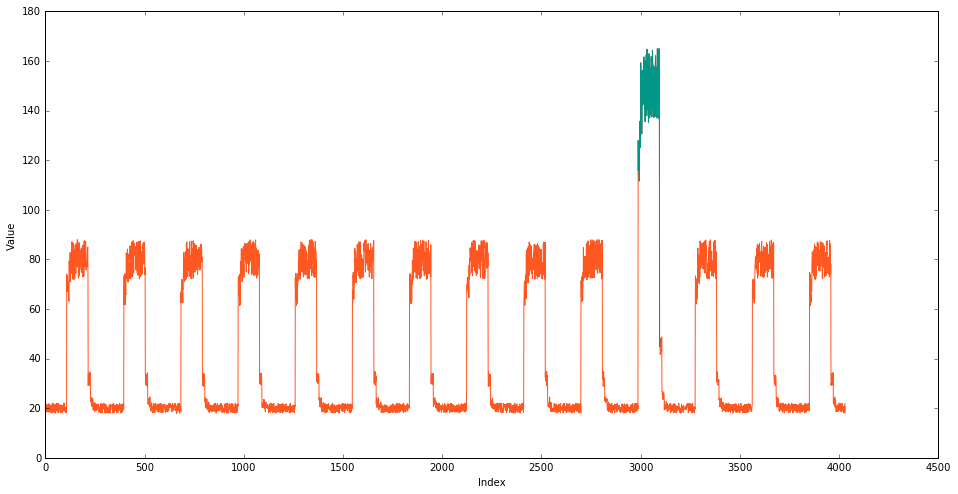

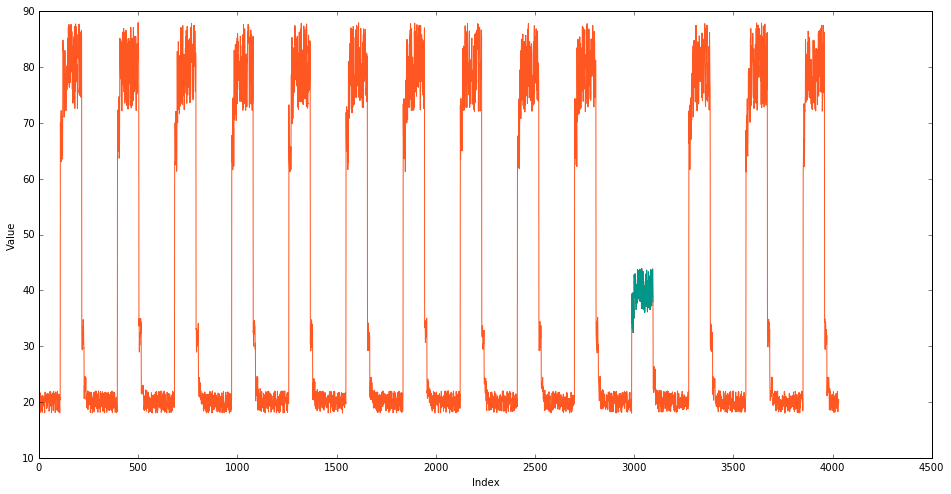

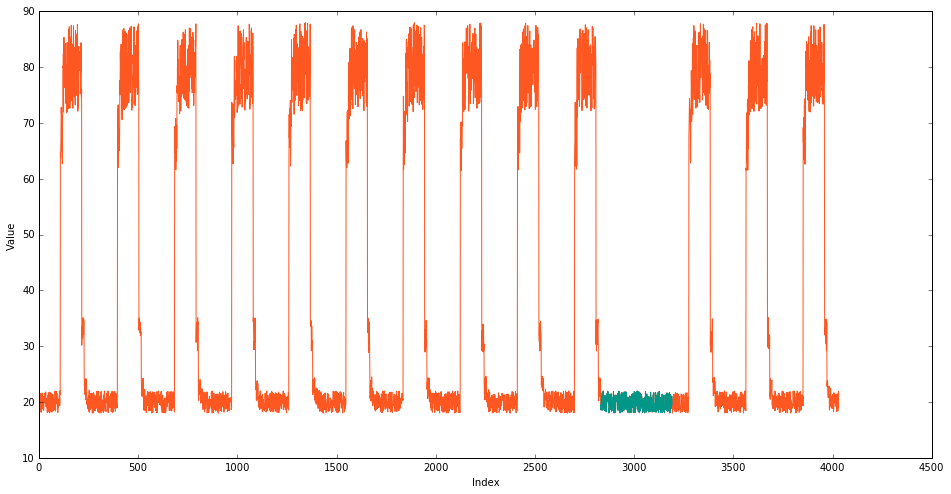

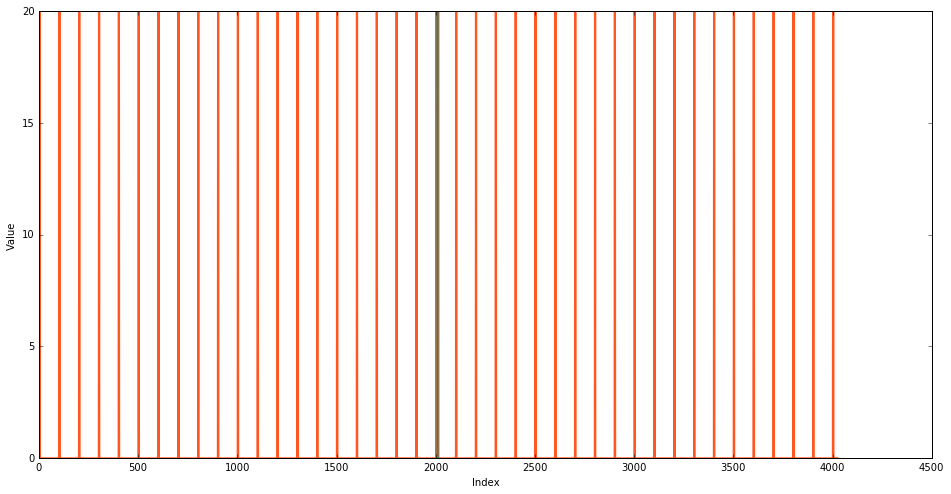

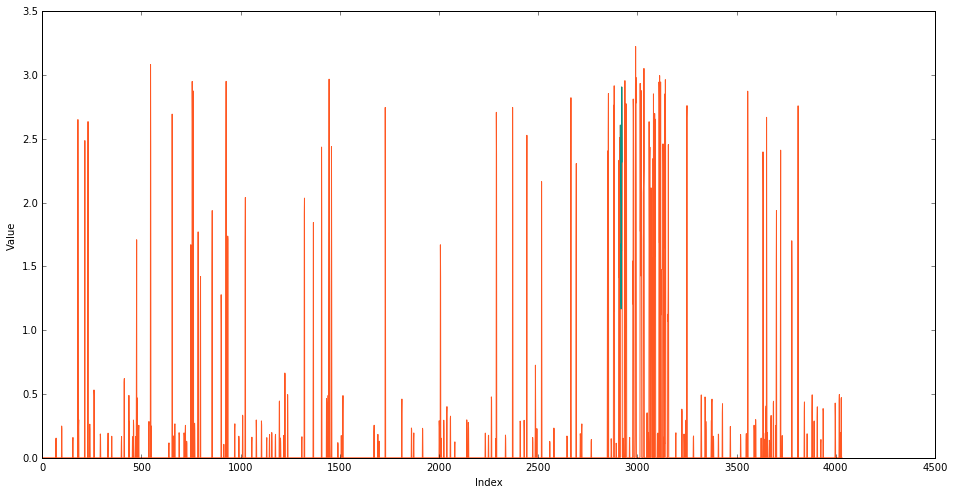

In [7]:
show_anomaly(ts1)
show_anomaly(ts2)
show_anomaly(ts3)
show_anomaly(ts4)
show_anomaly(ts5)